In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 11025
overlap = 5512

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 2.0605978965759277
(14019, 1, 11025)


In [12]:
a_data = c_data[targets == 0]
a_targ = c_targets[targets == 0]
i_data = c_data[targets == 1]
i_targ = c_targets[targets == 1]

In [13]:
names_a = []
for name in np.unique(a_targ):
    names_a.append(classes[name])
names_i = []
for name in np.unique(i_targ):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'crickets', 'chirping_birds', 'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'laughing', 'snoring']
['rain', 'sea_waves', 'crackling_fire', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'footsteps', 'brushing_teeth', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_1 (Melspec (None, 128, 44, 1)        296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 54ms/step - loss: 1424.5145
(1, 11025)


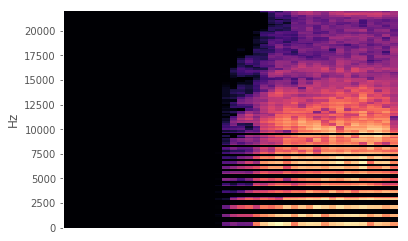

(14019, 128, 44)


In [16]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

src = np.random.random((1, blocksize))
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False,
    fmin = 800,
    fmax = 8000
))

check_model(model)
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)
n_targets = np.repeat(targets, mfccs.shape[1])
cat_targets = np.repeat(c_targets, mfccs.shape[1])

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 100
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, 11025),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu', input_shape=(128,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [18]:
frames = mfccs

In [19]:
frames = np.expand_dims(frames, axis=3)
frames.shape

(14019, 128, 44, 1)

In [20]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net, epochs=epochs, batch_size=batch, validation_split=0.15)
history = clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_2 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 36, 32)       2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total para

9532/9532 [==============================] - 29s 3ms/step - loss: 0.4239 - acc: 0.7933 - mean_absolute_error: 0.2934 - val_loss: 0.4856 - val_acc: 0.7522 - val_mean_absolute_error: 0.3089
Epoch 36/100
9532/9532 [==============================] - 29s 3ms/step - loss: 0.4317 - acc: 0.7867 - mean_absolute_error: 0.2955 - val_loss: 0.4940 - val_acc: 0.7623 - val_mean_absolute_error: 0.3398
Epoch 37/100
9532/9532 [==============================] - 29s 3ms/step - loss: 0.4217 - acc: 0.7939 - mean_absolute_error: 0.2910 - val_loss: 0.4669 - val_acc: 0.7588 - val_mean_absolute_error: 0.3112
Epoch 38/100
9532/9532 [==============================] - 29s 3ms/step - loss: 0.4123 - acc: 0.7989 - mean_absolute_error: 0.2858 - val_loss: 0.4898 - val_acc: 0.7534 - val_mean_absolute_error: 0.3189
Epoch 39/100
9532/9532 [==============================] - 29s 3ms/step - loss: 0.4092 - acc: 0.8015 - mean_absolute_error: 0.2822 - val_loss: 0.4738 - val_acc: 0.7534 - val_mean_absolute_error: 0.3013
Epoch 40

Epoch 76/100
9532/9532 [==============================] - 30s 3ms/step - loss: 0.3368 - acc: 0.8409 - mean_absolute_error: 0.2282 - val_loss: 0.4684 - val_acc: 0.7879 - val_mean_absolute_error: 0.2745
Epoch 77/100
9532/9532 [==============================] - 30s 3ms/step - loss: 0.3308 - acc: 0.8407 - mean_absolute_error: 0.2272 - val_loss: 0.4551 - val_acc: 0.7825 - val_mean_absolute_error: 0.2711
Epoch 78/100
9532/9532 [==============================] - 29s 3ms/step - loss: 0.3320 - acc: 0.8423 - mean_absolute_error: 0.2264 - val_loss: 0.4446 - val_acc: 0.7968 - val_mean_absolute_error: 0.2723
Epoch 79/100
9532/9532 [==============================] - 29s 3ms/step - loss: 0.3228 - acc: 0.8452 - mean_absolute_error: 0.2221 - val_loss: 0.4489 - val_acc: 0.7968 - val_mean_absolute_error: 0.2672
Epoch 80/100
9532/9532 [==============================] - 30s 3ms/step - loss: 0.3222 - acc: 0.8479 - mean_absolute_error: 0.2208 - val_loss: 0.4823 - val_acc: 0.7825 - val_mean_absolute_error: 0.

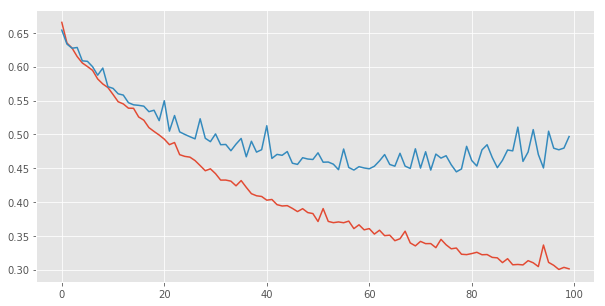

In [21]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

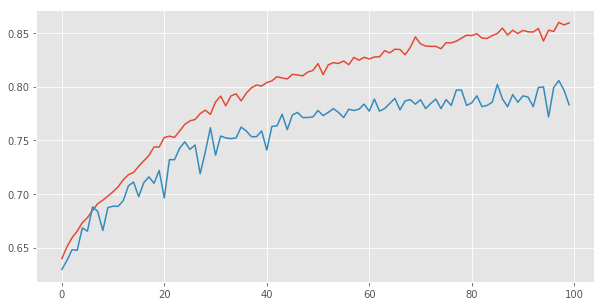

In [22]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.8106276747503567
Confusion matrix, without normalization
[[ 648  395]
 [ 136 1625]]


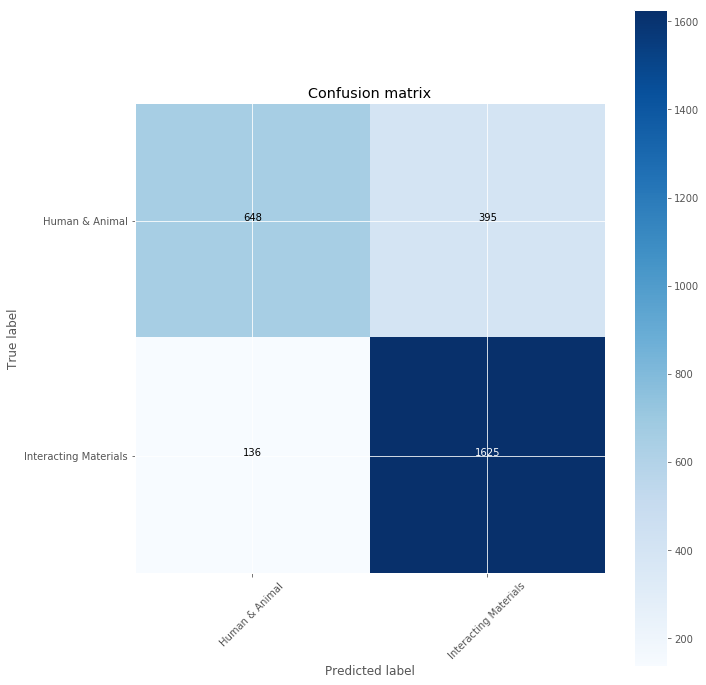

In [23]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# Deep Net
Separate into classes

# Animal Sounds

In [24]:
train_X, test_X, train_y, test_y = train_test_split(
                        a_data, a_targ, test_size=0.20, random_state=56)

In [25]:
def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, (3, 3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(19, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [26]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=epochs * 2, 
                       batch_size=batch, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_3 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 42, 32)       320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 2, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               41088     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

Epoch 31/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.8289 - acc: 0.4168 - mean_absolute_error: 0.0762 - val_loss: 1.7201 - val_acc: 0.4557 - val_mean_absolute_error: 0.0748
Epoch 32/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.8130 - acc: 0.4159 - mean_absolute_error: 0.0755 - val_loss: 1.7121 - val_acc: 0.4348 - val_mean_absolute_error: 0.0742
Epoch 33/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.7804 - acc: 0.4302 - mean_absolute_error: 0.0750 - val_loss: 1.7047 - val_acc: 0.4718 - val_mean_absolute_error: 0.0726
Epoch 34/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.7751 - acc: 0.4361 - mean_absolute_error: 0.0746 - val_loss: 1.6980 - val_acc: 0.4461 - val_mean_absolute_error: 0.0724
Epoch 35/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.7679 - acc: 0.4267 - mean_absolute_error: 0.0741 - val_loss: 1.6486 - val_acc: 0.4911 - val_mean_absolute_error: 0.0718


Epoch 72/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.4126 - acc: 0.5508 - mean_absolute_error: 0.0613 - val_loss: 1.4239 - val_acc: 0.5443 - val_mean_absolute_error: 0.0608
Epoch 73/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.4638 - acc: 0.5363 - mean_absolute_error: 0.0629 - val_loss: 1.4061 - val_acc: 0.5556 - val_mean_absolute_error: 0.0619
Epoch 74/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.4513 - acc: 0.5309 - mean_absolute_error: 0.0624 - val_loss: 1.4590 - val_acc: 0.5604 - val_mean_absolute_error: 0.0614
Epoch 75/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.3967 - acc: 0.5536 - mean_absolute_error: 0.0616 - val_loss: 1.4558 - val_acc: 0.5556 - val_mean_absolute_error: 0.0612
Epoch 76/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.3847 - acc: 0.5630 - mean_absolute_error: 0.0604 - val_loss: 1.3966 - val_acc: 0.5652 - val_mean_absolute_error: 0.0602


Epoch 113/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.2332 - acc: 0.6080 - mean_absolute_error: 0.0550 - val_loss: 1.3250 - val_acc: 0.5958 - val_mean_absolute_error: 0.0552
Epoch 114/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.2319 - acc: 0.6031 - mean_absolute_error: 0.0550 - val_loss: 1.2822 - val_acc: 0.5990 - val_mean_absolute_error: 0.0550
Epoch 115/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.2438 - acc: 0.5974 - mean_absolute_error: 0.0551 - val_loss: 1.3061 - val_acc: 0.6006 - val_mean_absolute_error: 0.0572
Epoch 116/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.2159 - acc: 0.6074 - mean_absolute_error: 0.0550 - val_loss: 1.2980 - val_acc: 0.5958 - val_mean_absolute_error: 0.0560
Epoch 117/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.2131 - acc: 0.6105 - mean_absolute_error: 0.0541 - val_loss: 1.3431 - val_acc: 0.6071 - val_mean_absolute_error: 0.

Epoch 154/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.0562 - acc: 0.6589 - mean_absolute_error: 0.0491 - val_loss: 1.1907 - val_acc: 0.6473 - val_mean_absolute_error: 0.0500
Epoch 155/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.1023 - acc: 0.6541 - mean_absolute_error: 0.0496 - val_loss: 1.3279 - val_acc: 0.6055 - val_mean_absolute_error: 0.0537
Epoch 156/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.1091 - acc: 0.6452 - mean_absolute_error: 0.0496 - val_loss: 1.2219 - val_acc: 0.6232 - val_mean_absolute_error: 0.0510
Epoch 157/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.0814 - acc: 0.6523 - mean_absolute_error: 0.0497 - val_loss: 1.2446 - val_acc: 0.6119 - val_mean_absolute_error: 0.0524
Epoch 158/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.0737 - acc: 0.6475 - mean_absolute_error: 0.0484 - val_loss: 1.2681 - val_acc: 0.6280 - val_mean_absolute_error: 0.

Epoch 195/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.0261 - acc: 0.6609 - mean_absolute_error: 0.0465 - val_loss: 1.2550 - val_acc: 0.6216 - val_mean_absolute_error: 0.0495
Epoch 196/200
3515/3515 [==============================] - 5s 1ms/step - loss: 0.9460 - acc: 0.6885 - mean_absolute_error: 0.0443 - val_loss: 1.2209 - val_acc: 0.6506 - val_mean_absolute_error: 0.0482
Epoch 197/200
3515/3515 [==============================] - 5s 1ms/step - loss: 0.9848 - acc: 0.6780 - mean_absolute_error: 0.0454 - val_loss: 1.1890 - val_acc: 0.6490 - val_mean_absolute_error: 0.0480
Epoch 198/200
3515/3515 [==============================] - 5s 1ms/step - loss: 0.9582 - acc: 0.6947 - mean_absolute_error: 0.0437 - val_loss: 1.2340 - val_acc: 0.6264 - val_mean_absolute_error: 0.0509
Epoch 199/200
3515/3515 [==============================] - 5s 1ms/step - loss: 1.0587 - acc: 0.6745 - mean_absolute_error: 0.0474 - val_loss: 1.2572 - val_acc: 0.6457 - val_mean_absolute_error: 0.

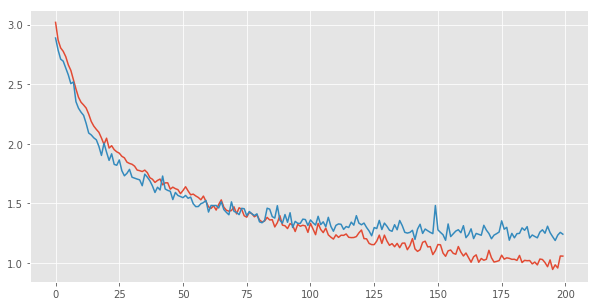

In [27]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

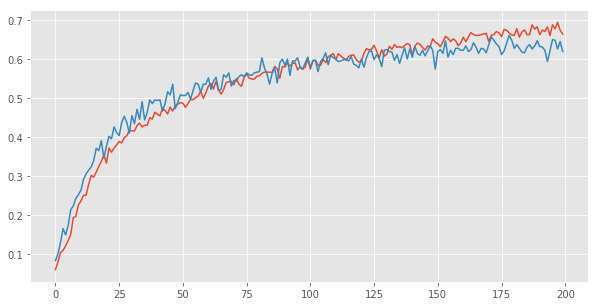

In [28]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.6009661835748792
Confusion matrix, without normalization
[[36  0  0  1  0  7  1  0  0  1  0  0  1  3  0  0  0  1  2]
 [ 7 19  0  2  4  1  1  0  0  4  0  0  1  2  0  0  1  0  0]
 [ 0  0 37  0  1  0  5  9  0  0  0  1  0  0  0  2  0  0  0]
 [ 1  1  1 23  1  4  2  9  1  2  1  0  2  5  0  0  0  4  7]
 [ 2  1  0  0 37  0  1  1  0  2  0  0  0  0  2  1  0  0  1]
 [ 0  1  0  0  0 36  1  1  2  0  1  1  1  2  0  0  1  0  2]
 [ 2  0  9  0  1  2 30  1  0  3  0  2  1  1  0  0  2  1  1]
 [ 1  1  6  2  0  1  1 23  0  0  2  0  0  0  0  0  0  0 11]
 [ 2  0  0  2  5  7  1  8 46  1  0  0  0  0  1  0  0  3  2]
 [ 0  1  1  3  3  0  2  2  0 40  1  0  0  1  0  1  0  0  3]
 [ 0  0  0  0  0  0  0  2  0  0 70  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  1  3  0  3  0  2  1 47  0  1  0  0  0  0  4]
 [ 2  2  3  0  0  9  7  1  4  1  0  2 17  2  1  0  0  2  6]
 [ 0  0  0  0  1  0  2  0  0  2  0  1  0 14  1  1  0  3  4]
 [ 0  0  1  0  1  0  0  1  0  0  0  0  0  1 53  0  1  0  0]
 [ 1  0  2  0  2  0  2  2  1  1  0  0  1 

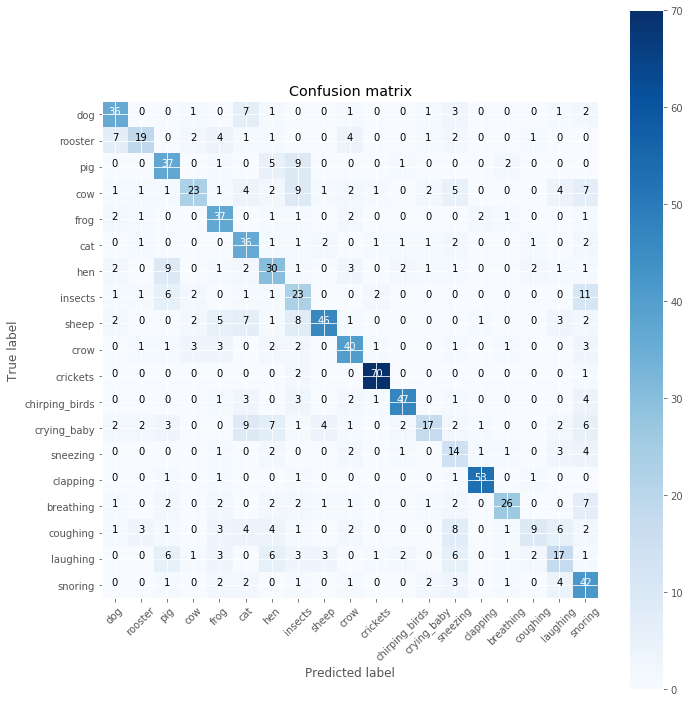

In [29]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

# Interacting Materials

In [30]:
train_X, test_X, train_y, test_y = train_test_split(
                        i_data, i_targ, test_size=0.20, random_state=75)

In [31]:
def gpu_mfcc_deep_net_i():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(16, (3,3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Convolution2D(32, (5,2), name='conv2', activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(31, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [32]:
inter = KerasClassifier(build_fn=gpu_mfcc_deep_net_i, epochs=epochs * 2, batch_size=batch, validation_split=0.15)
history = inter.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_4 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 42, 16)       160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 2, 16)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 1, 32)          5152      
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

6016/6016 [==============================] - 5s 903us/step - loss: 1.8660 - acc: 0.3851 - mean_absolute_error: 0.0479 - val_loss: 1.7965 - val_acc: 0.4228 - val_mean_absolute_error: 0.0462
Epoch 31/200
6016/6016 [==============================] - 5s 910us/step - loss: 1.8302 - acc: 0.3979 - mean_absolute_error: 0.0474 - val_loss: 1.7311 - val_acc: 0.4397 - val_mean_absolute_error: 0.0450
Epoch 32/200
6016/6016 [==============================] - 6s 915us/step - loss: 1.8589 - acc: 0.3880 - mean_absolute_error: 0.0478 - val_loss: 1.7221 - val_acc: 0.4435 - val_mean_absolute_error: 0.0461
Epoch 33/200
6016/6016 [==============================] - 5s 908us/step - loss: 1.8057 - acc: 0.4023 - mean_absolute_error: 0.0471 - val_loss: 1.7327 - val_acc: 0.4576 - val_mean_absolute_error: 0.0447
Epoch 34/200
6016/6016 [==============================] - 5s 911us/step - loss: 1.8679 - acc: 0.3878 - mean_absolute_error: 0.0475 - val_loss: 1.7463 - val_acc: 0.4548 - val_mean_absolute_error: 0.0459
Epo

Epoch 71/200
6016/6016 [==============================] - 6s 915us/step - loss: 1.4834 - acc: 0.5073 - mean_absolute_error: 0.0404 - val_loss: 1.4518 - val_acc: 0.5443 - val_mean_absolute_error: 0.0382
Epoch 72/200
6016/6016 [==============================] - 5s 889us/step - loss: 1.5145 - acc: 0.4992 - mean_absolute_error: 0.0408 - val_loss: 1.5438 - val_acc: 0.5009 - val_mean_absolute_error: 0.0411
Epoch 73/200
6016/6016 [==============================] - 5s 884us/step - loss: 1.5687 - acc: 0.4860 - mean_absolute_error: 0.0420 - val_loss: 1.4435 - val_acc: 0.5433 - val_mean_absolute_error: 0.0378
Epoch 74/200
6016/6016 [==============================] - 5s 908us/step - loss: 1.5012 - acc: 0.5028 - mean_absolute_error: 0.0407 - val_loss: 1.4699 - val_acc: 0.5301 - val_mean_absolute_error: 0.0377
Epoch 75/200
6016/6016 [==============================] - 5s 904us/step - loss: 1.4743 - acc: 0.5088 - mean_absolute_error: 0.0401 - val_loss: 1.4573 - val_acc: 0.5311 - val_mean_absolute_erro

6016/6016 [==============================] - 5s 899us/step - loss: 1.3971 - acc: 0.5359 - mean_absolute_error: 0.0384 - val_loss: 1.4025 - val_acc: 0.5621 - val_mean_absolute_error: 0.0365
Epoch 112/200
6016/6016 [==============================] - 5s 893us/step - loss: 1.3742 - acc: 0.5396 - mean_absolute_error: 0.0381 - val_loss: 1.3716 - val_acc: 0.5800 - val_mean_absolute_error: 0.0348
Epoch 113/200
6016/6016 [==============================] - 5s 902us/step - loss: 1.3418 - acc: 0.5509 - mean_absolute_error: 0.0373 - val_loss: 1.3297 - val_acc: 0.5810 - val_mean_absolute_error: 0.0345
Epoch 114/200
6016/6016 [==============================] - 5s 900us/step - loss: 1.3442 - acc: 0.5502 - mean_absolute_error: 0.0369 - val_loss: 1.3060 - val_acc: 0.5932 - val_mean_absolute_error: 0.0351
Epoch 115/200
6016/6016 [==============================] - 5s 883us/step - loss: 1.3264 - acc: 0.5544 - mean_absolute_error: 0.0368 - val_loss: 1.3462 - val_acc: 0.5697 - val_mean_absolute_error: 0.0351

6016/6016 [==============================] - 5s 909us/step - loss: 1.2407 - acc: 0.5839 - mean_absolute_error: 0.0346 - val_loss: 1.2401 - val_acc: 0.6055 - val_mean_absolute_error: 0.0325
Epoch 152/200
6016/6016 [==============================] - 5s 893us/step - loss: 1.1945 - acc: 0.5918 - mean_absolute_error: 0.0337 - val_loss: 1.3237 - val_acc: 0.5725 - val_mean_absolute_error: 0.0326
Epoch 153/200
6016/6016 [==============================] - 5s 892us/step - loss: 1.2226 - acc: 0.5879 - mean_absolute_error: 0.0344 - val_loss: 1.2413 - val_acc: 0.6055 - val_mean_absolute_error: 0.0321
Epoch 154/200
6016/6016 [==============================] - 6s 918us/step - loss: 1.1961 - acc: 0.6027 - mean_absolute_error: 0.0336 - val_loss: 1.2668 - val_acc: 0.6017 - val_mean_absolute_error: 0.0328
Epoch 155/200
6016/6016 [==============================] - 6s 915us/step - loss: 1.1781 - acc: 0.6001 - mean_absolute_error: 0.0334 - val_loss: 1.2705 - val_acc: 0.5970 - val_mean_absolute_error: 0.0328

6016/6016 [==============================] - 5s 903us/step - loss: 1.1952 - acc: 0.6056 - mean_absolute_error: 0.0338 - val_loss: 1.2466 - val_acc: 0.6234 - val_mean_absolute_error: 0.0309
Epoch 192/200
6016/6016 [==============================] - 5s 889us/step - loss: 1.1731 - acc: 0.6064 - mean_absolute_error: 0.0328 - val_loss: 1.2384 - val_acc: 0.6177 - val_mean_absolute_error: 0.0320
Epoch 193/200
6016/6016 [==============================] - 5s 887us/step - loss: 1.1368 - acc: 0.6185 - mean_absolute_error: 0.0324 - val_loss: 1.2928 - val_acc: 0.5951 - val_mean_absolute_error: 0.0320
Epoch 194/200
6016/6016 [==============================] - 5s 893us/step - loss: 1.1402 - acc: 0.6165 - mean_absolute_error: 0.0323 - val_loss: 1.2103 - val_acc: 0.6375 - val_mean_absolute_error: 0.0305
Epoch 195/200
6016/6016 [==============================] - 5s 897us/step - loss: 1.1157 - acc: 0.6243 - mean_absolute_error: 0.0318 - val_loss: 1.2839 - val_acc: 0.6139 - val_mean_absolute_error: 0.0308

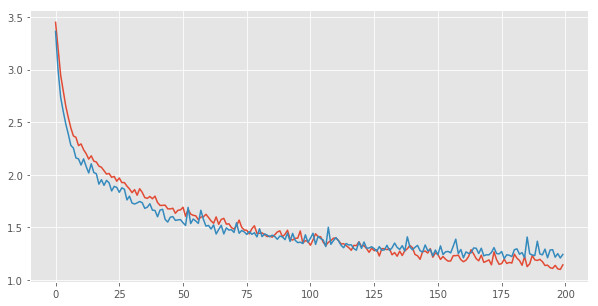

In [33]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

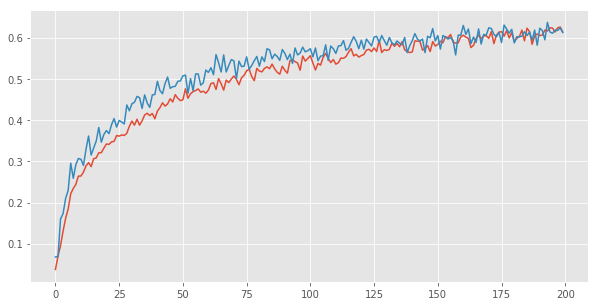

In [34]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.6033898305084746
Confusion matrix, without normalization
[[55  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 51  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  2  0  0  0  0  0]
 [ 0  0 50  0  0  0  2  0  1  0  0  0  0  4  0  1  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 20  0  1  0  3  2  1  0  1  3  0  2  5  0  0  3  1  0  0  0  0
   0  0  0  0  0  4  0]
 [ 5 14  0  0 43  0  0  0  0  2  0  0  0  0  0  0  0  1  0  0  0  1  1  0
   0  2  0  0  0  0  0]
 [ 0  0  3  0  0 20  0  0  4  0  1  0  0  6  1  4  0  0  2  0  2  0  0  0
   0  0  0  0  0  0  0]
 [ 4  2  1  1  1  0 33  1  0  3  0  0  0  0  0  0  0  1  1  0  0  0  1  1
   0  2  0  0  0  0  0]
 [ 0  2  0  0  7  0  0 24  5  0  0  0  0  0  0  1  0  0  0  0  0  3  0  0
   0  1  1  0  6 10  1]
 [ 0  0  5  0  1  1  0  0 30  0  1  0  1  9  0  0  0  0  0  2  0  0  0  0
   0  0  0  0  0  1  0]
 [ 0  1  8  0  0  2  7  1  1 33  0  0  0  0  0  0  0  0  1 

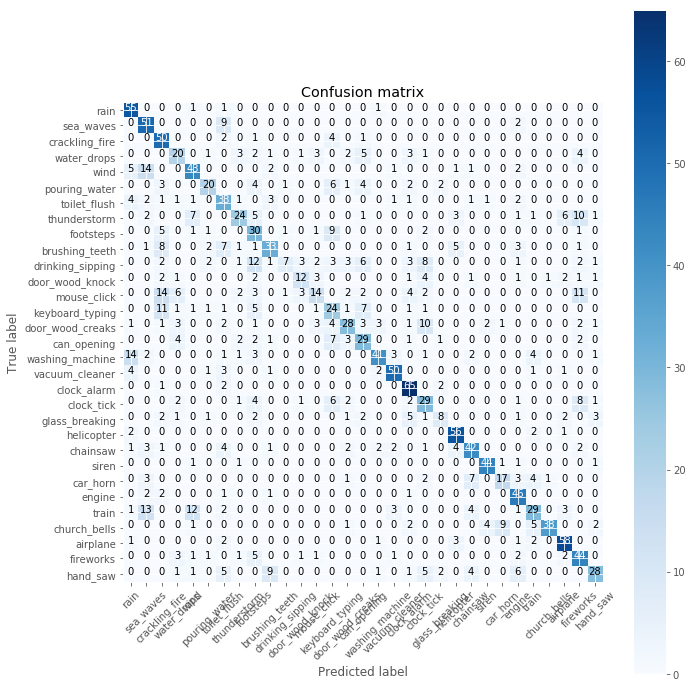

In [35]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# All Data

In [36]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 2.8743810653686523
	Processing Time: 2.316044807434082
	Processing Time: 2.6480720043182373
	Processing Time: 2.757493257522583


In [37]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(56774, 1, 11025)


In [38]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(56774,)


In [39]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(56774,)


0.7242047416070737
Confusion matrix, without normalization
[[10807 10297]
 [ 5361 30309]]


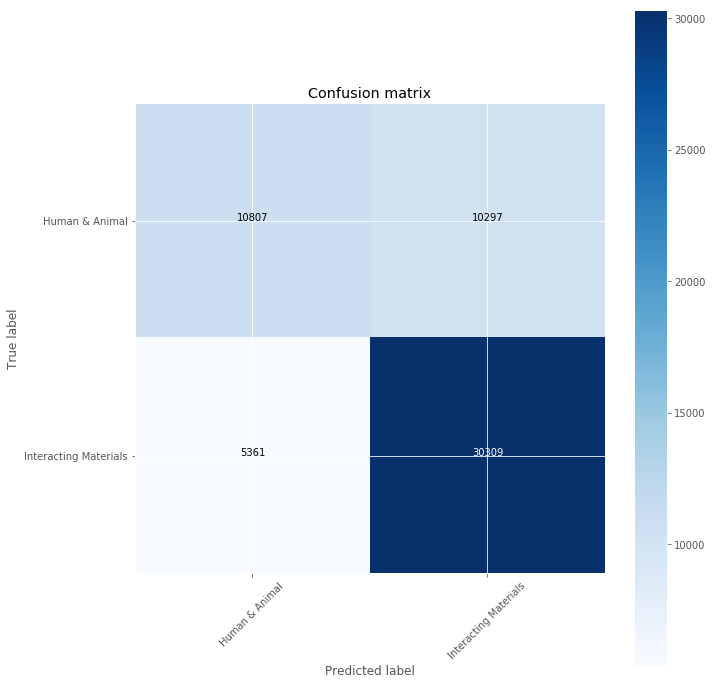

In [40]:
pred = clas.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [41]:
test_a_data = X[y == 0]
test_a_targ = yy[y == 0]
test_i_data = X[y == 1]
test_i_targ = yy[y == 1]

0.3134003032600455
Confusion matrix, without normalization
[[477  10  28  39  18  49 149   5  19  22   0   4  30  82  23  27  25  55
   45]
 [ 73 243   5  28  36  78  65   1   7  65   9   7  24 121   3   7  22  59
   32]
 [  9   8 337  20  17   7 103 121  27  86  36  14  17  11  88  22  40  35
   78]
 [127   9  34 282  20  58 221  68  44  33  22  18  33  15   2  20  17  36
   54]
 [ 91  39  80  20 490  11   3  25  43  98  10  86   9  22 110  51   7  34
   15]
 [107 106   5  59  21 202  58  29  29  30  12  21  52  46   9   6  24  65
  148]
 [163  14  70  24  16  50 395  56  17   9  25   8  79   9   5  62  25  73
   53]
 [ 22   2 131  54  39  58  48 524  41  29  29  11  35   4  55  10  11   7
  101]
 [ 30   9  38 125  97  56  44 167 314  97  12  39  10   8  53  45  24  22
   44]
 [ 57   8  69  40  92  10  89  79  76 470  18  15   2   3  40  11   5  13
   40]
 [ 16   0  41   3   2  23   0  75   3  84 289 493   4   7   1   2  13   0
  192]
 [ 26   2 100   8  15  29  46  57  43  18 172 563 

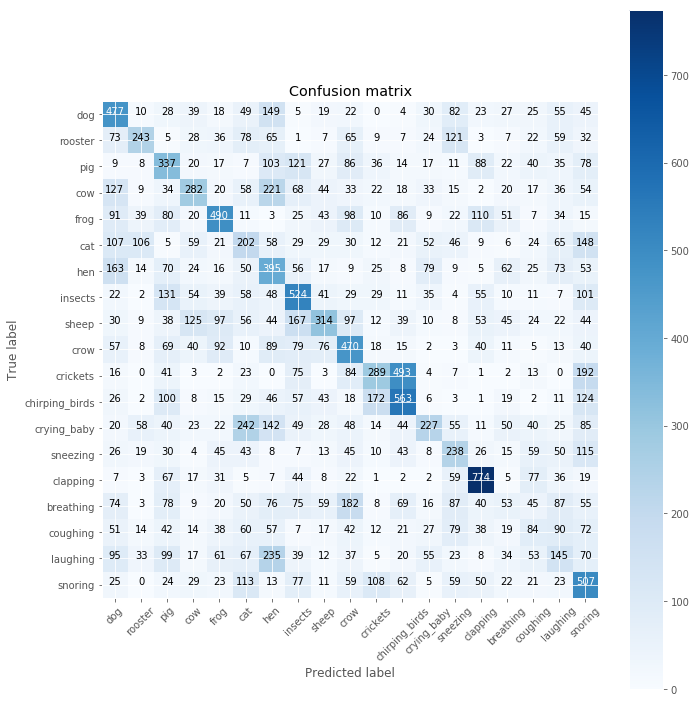

In [42]:
pred = anim.predict(test_a_data)
print(metrics.accuracy_score(test_a_targ, pred))
cm = metrics.confusion_matrix(test_a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

0.1952340902719372
Confusion matrix, without normalization
[[320  15   8   0  41   0 451  14   0   0   0   0   0   0  23   2  23   7
    0   0  12  17  35   0   0  36   0   0 243   0   1]
 [ 42 259   3   2  17   0 505   1   2   0   0   0   1   0   2   0  18  17
    4   1   0  31 210   0   1  33   2  27  61   1   2]
 [ 29  14 366   1  12  32 143  12  26  76   3   1   6  71  99  41   5  26
    1   8   5  75  75   0   0  60   0   1   1  19   6]
 [  0   0  75 124  12  66   6  54  76  15  26  32  49  67  29 118   0   0
   43  74  20   3  13   8   2  13   0  11   8  59  29]
 [  1 230   0   0 299   0  16   5   0  10   0   3   0   0   0   0  19  10
    0   0   3   4 118 119  33 116 201  13   6   0  42]
 [  0   2 120  29   1 261 159   2  17  22  22  33   0 120  30  68   0   2
   63  25  33   2 127   5   0  11   0   0   0   9  18]
 [139  32  26   3  18   8 585  11  26  60   6   4   2   7  16   2  42  13
    3   6  20  28  63   4   0  21   5   0  47   6  35]
 [ 37  28   6   3 152  21  24 190  21 

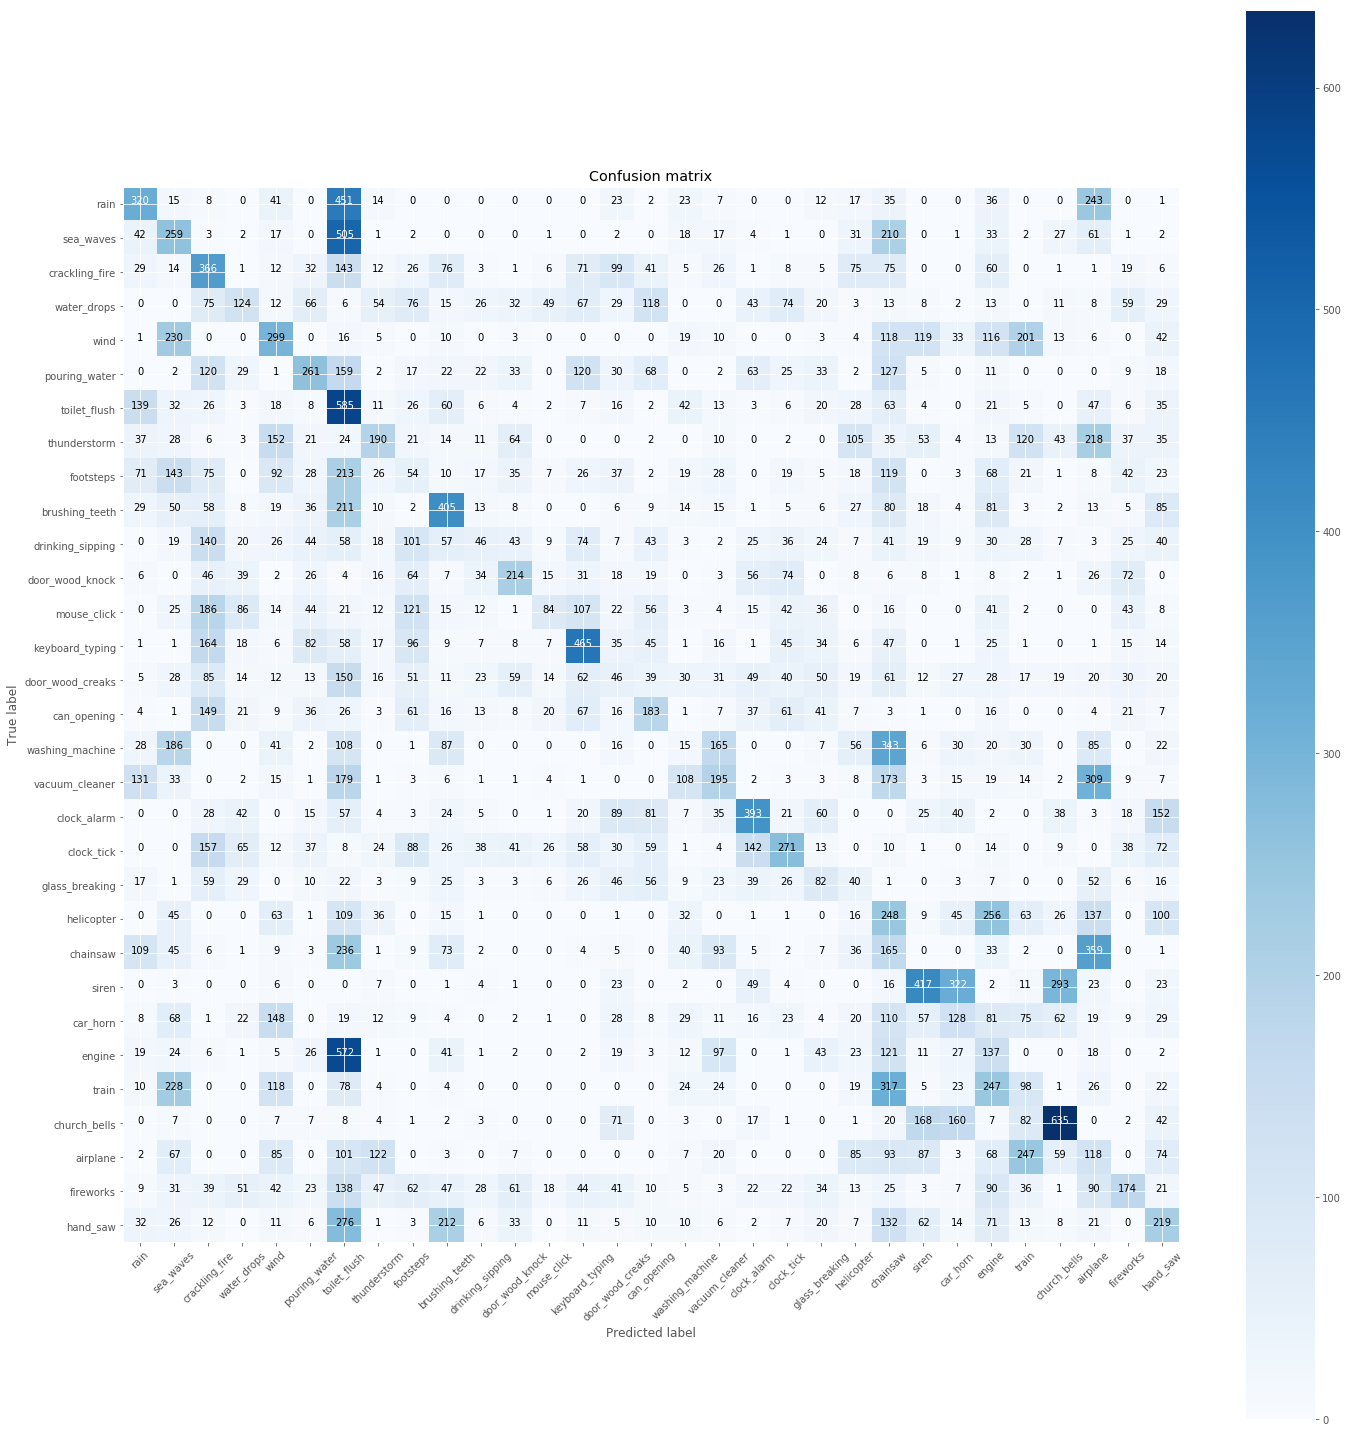

In [43]:
pred = inter.predict(test_i_data)
print(metrics.accuracy_score(test_i_targ, pred))
cm = metrics.confusion_matrix(test_i_targ, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, names_i)
plt.show()

In [44]:
clas.predict_proba(X)

array([[5.7339668e-05, 9.9994266e-01],
       [3.5762787e-07, 9.9999964e-01],
       [7.1730644e-01, 2.8269356e-01],
       ...,
       [2.8391975e-01, 7.1608025e-01],
       [2.9503906e-01, 7.0496094e-01],
       [2.9477763e-01, 7.0522237e-01]], dtype=float32)

# Testing Accuracy of Single File

In [45]:
data_iloc = 1

In [46]:
def load_file_audio_blockwise(file, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    h_cat = []
    cat = []

    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + file['filename'], 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True, 
                         fill_value=0.0)
    SR = sf.info(audio_dir + file['filename']).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        h_cat.append(file.h_category)
        cat.append(file.target)
    if debug:
        print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

In [47]:
x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)

	Processing Time: 0.008224010467529297


In [48]:
pred_prob = clas.predict_proba(x_file, verbose=1)
pred = clas.predict(x_file, verbose=1)

39/39 [==============================] - 0s 641us/step


In [49]:
np.average(pred_prob, axis=0)

array([0.8035615 , 0.19643843], dtype=float32)

In [50]:
pred_prob = anim.predict_proba(x_file, verbose=1)
pred = anim.predict(x_file, verbose=1)

39/39 [==============================] - 0s 336us/step


In [51]:
np.average(pred_prob, axis=0)

array([2.2467560e-05, 2.0647743e-03, 2.2562657e-01, 4.9046050e-03,
       1.7193487e-03, 2.3854572e-04, 9.7225932e-03, 2.4586638e-02,
       4.3712971e-03, 3.3162817e-02, 1.5685260e-03, 4.9490523e-01,
       2.5526294e-02, 1.8698715e-02, 5.5420969e-04, 5.9367266e-02,
       1.7103964e-02, 4.0423770e-02, 3.5432421e-02], dtype=float32)

In [52]:
from collections import Counter
b = Counter(pred)
print(b.most_common(1)[0][0])

14


In [53]:
print(dataset.iloc[data_iloc])

filename      1-100038-A-14.wav
fold                          1
target                       14
category         chirping_birds
esc10                     False
src_file                 100038
take                          A
h_category                    0
Name: 1, dtype: object


In [54]:
predictions = []
full_targets = []
start_time = time.time()
top_pred_probs = []
pred_probs = []

for data_iloc in range(0,2000):
    x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)
    pred = clas.predict(x_file, verbose=0)[:,0]
    top_pred_probs.append(clas.predict_proba(x_file))
    prob = np.average(top_pred_probs[-1], axis=0)
    if prob[0] > 0.5:
        pred = anim.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
        pred_probs.append(anim.predict_proba(x_file))
    else:
        pred = inter.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
        pred_probs.append(inter.predict_proba(x_file))
    
    full_targets.append(yy_file[0])

print("\tProcessing Time: " + str(time.time() - start_time))

	Processing Time: 0.004538297653198242
	Processing Time: 0.006964445114135742
	Processing Time: 0.0071218013763427734
	Processing Time: 0.008191585540771484
	Processing Time: 0.005590200424194336
	Processing Time: 0.005901813507080078
	Processing Time: 0.005160331726074219
	Processing Time: 0.006206512451171875
	Processing Time: 0.005850076675415039
	Processing Time: 0.003983974456787109
	Processing Time: 0.0040667057037353516
	Processing Time: 0.0057451725006103516
	Processing Time: 0.00537562370300293
	Processing Time: 0.005479574203491211
	Processing Time: 0.0036897659301757812
	Processing Time: 0.00645136833190918
	Processing Time: 0.0068852901458740234
	Processing Time: 0.006170988082885742
	Processing Time: 0.0053637027740478516
	Processing Time: 0.005401611328125
	Processing Time: 0.0052776336669921875
	Processing Time: 0.005535602569580078
	Processing Time: 0.008576154708862305
	Processing Time: 0.00649714469909668
	Processing Time: 0.006000995635986328
	Processing Time: 0.0060

	Processing Time: 0.006742954254150391
	Processing Time: 0.0035419464111328125
	Processing Time: 0.0047702789306640625
	Processing Time: 0.004654645919799805
	Processing Time: 0.00486445426940918
	Processing Time: 0.004519224166870117
	Processing Time: 0.00453495979309082
	Processing Time: 0.0047113895416259766
	Processing Time: 0.004819393157958984
	Processing Time: 0.004773855209350586
	Processing Time: 0.00450587272644043
	Processing Time: 0.00477910041809082
	Processing Time: 0.004760265350341797
	Processing Time: 0.004026651382446289
	Processing Time: 0.003609895706176758
	Processing Time: 0.004459857940673828
	Processing Time: 0.004872322082519531
	Processing Time: 0.005270957946777344
	Processing Time: 0.004734516143798828
	Processing Time: 0.007328510284423828
	Processing Time: 0.0044629573822021484
	Processing Time: 0.0060880184173583984
	Processing Time: 0.005410671234130859
	Processing Time: 0.004374980926513672
	Processing Time: 0.005092620849609375
	Processing Time: 0.0048

	Processing Time: 0.0034470558166503906
	Processing Time: 0.0034821033477783203
	Processing Time: 0.004498720169067383
	Processing Time: 0.004743337631225586
	Processing Time: 0.004733562469482422
	Processing Time: 0.004476070404052734
	Processing Time: 0.0047490596771240234
	Processing Time: 0.004853010177612305
	Processing Time: 0.00467991828918457
	Processing Time: 0.004732847213745117
	Processing Time: 0.0046329498291015625
	Processing Time: 0.0047037601470947266
	Processing Time: 0.0046961307525634766
	Processing Time: 0.004704713821411133
	Processing Time: 0.004732847213745117
	Processing Time: 0.004716157913208008
	Processing Time: 0.004720211029052734
	Processing Time: 0.005106687545776367
	Processing Time: 0.0050945281982421875
	Processing Time: 0.004806995391845703
	Processing Time: 0.0043659210205078125
	Processing Time: 0.004588603973388672
	Processing Time: 0.004808902740478516
	Processing Time: 0.005376338958740234
	Processing Time: 0.0047016143798828125
	Processing Time:

	Processing Time: 0.0051000118255615234
	Processing Time: 0.005295991897583008
	Processing Time: 0.006753683090209961
	Processing Time: 0.004750490188598633
	Processing Time: 0.004836082458496094
	Processing Time: 0.004682779312133789
	Processing Time: 0.005704164505004883
	Processing Time: 0.004858493804931641
	Processing Time: 0.006428956985473633
	Processing Time: 0.005656003952026367
	Processing Time: 0.0047643184661865234
	Processing Time: 0.0042955875396728516
	Processing Time: 0.004709959030151367
	Processing Time: 0.005243062973022461
	Processing Time: 0.004889011383056641
	Processing Time: 0.005827426910400391
	Processing Time: 0.005839824676513672
	Processing Time: 0.00412440299987793
	Processing Time: 0.005918264389038086
	Processing Time: 0.006479024887084961
	Processing Time: 0.005709171295166016
	Processing Time: 0.0046749114990234375
	Processing Time: 0.005979776382446289
	Processing Time: 0.00540614128112793
	Processing Time: 0.005431175231933594
	Processing Time: 0.005

	Processing Time: 0.005000591278076172
	Processing Time: 0.0038008689880371094
	Processing Time: 0.005852699279785156
	Processing Time: 0.00476527214050293
	Processing Time: 0.005231380462646484
	Processing Time: 0.004780769348144531
	Processing Time: 0.004815340042114258
	Processing Time: 0.0047910213470458984
	Processing Time: 0.004782438278198242
	Processing Time: 0.004863262176513672
	Processing Time: 0.0034792423248291016
	Processing Time: 0.004664182662963867
	Processing Time: 0.004727840423583984
	Processing Time: 0.00494074821472168
	Processing Time: 0.00474238395690918
	Processing Time: 0.004911899566650391
	Processing Time: 0.0060520172119140625
	Processing Time: 0.004775047302246094
	Processing Time: 0.005563259124755859
	Processing Time: 0.005473136901855469
	Processing Time: 0.004837512969970703
	Processing Time: 0.00536036491394043
	Processing Time: 0.005445718765258789
	Processing Time: 0.005452156066894531
	Processing Time: 0.0086822509765625
	Processing Time: 0.0064549

	Processing Time: 0.004576206207275391
	Processing Time: 0.005163431167602539
	Processing Time: 0.004655599594116211
	Processing Time: 0.004805803298950195
	Processing Time: 0.004859209060668945
	Processing Time: 0.004814624786376953
	Processing Time: 0.005869150161743164
	Processing Time: 0.005753040313720703
	Processing Time: 0.004935264587402344
	Processing Time: 0.004531383514404297
	Processing Time: 0.0048580169677734375
	Processing Time: 0.0048084259033203125
	Processing Time: 0.004136800765991211
	Processing Time: 0.0052051544189453125
	Processing Time: 0.004869699478149414
	Processing Time: 0.005749940872192383
	Processing Time: 0.004822969436645508
	Processing Time: 0.00394892692565918
	Processing Time: 0.003551006317138672
	Processing Time: 0.005512714385986328
	Processing Time: 0.004798173904418945
	Processing Time: 0.004837751388549805
	Processing Time: 0.004781246185302734
	Processing Time: 0.005427837371826172
	Processing Time: 0.004812955856323242
	Processing Time: 0.005

	Processing Time: 0.004841327667236328
	Processing Time: 0.004858255386352539
	Processing Time: 0.004808187484741211
	Processing Time: 0.004765033721923828
	Processing Time: 0.004793643951416016
	Processing Time: 0.004869937896728516
	Processing Time: 0.004732847213745117
	Processing Time: 0.004701137542724609
	Processing Time: 0.004710674285888672
	Processing Time: 0.00482487678527832
	Processing Time: 0.005020618438720703
	Processing Time: 0.0038809776306152344
	Processing Time: 0.005331993103027344
	Processing Time: 0.004822254180908203
	Processing Time: 0.0032405853271484375
	Processing Time: 0.004899024963378906
	Processing Time: 0.0047779083251953125
	Processing Time: 0.004174947738647461
	Processing Time: 0.004837989807128906
	Processing Time: 0.00489354133605957
	Processing Time: 0.004839897155761719
	Processing Time: 0.0034520626068115234
	Processing Time: 0.004708528518676758
	Processing Time: 0.005078554153442383
	Processing Time: 0.00483393669128418
	Processing Time: 0.0047

	Processing Time: 0.006028175354003906
	Processing Time: 0.004759550094604492
	Processing Time: 0.004672527313232422
	Processing Time: 0.0059359073638916016
	Processing Time: 0.004880428314208984
	Processing Time: 0.004716396331787109
	Processing Time: 0.004716396331787109
	Processing Time: 0.004810810089111328
	Processing Time: 0.004715919494628906
	Processing Time: 0.004724025726318359
	Processing Time: 0.004736900329589844
	Processing Time: 0.004866361618041992
	Processing Time: 0.00485682487487793
	Processing Time: 0.004703998565673828
	Processing Time: 0.004757404327392578
	Processing Time: 0.0033004283905029297
	Processing Time: 0.004564523696899414
	Processing Time: 0.0050106048583984375
	Processing Time: 0.004830837249755859
	Processing Time: 0.004862308502197266
	Processing Time: 0.00477290153503418
	Processing Time: 0.00510096549987793
	Processing Time: 0.004998683929443359
	Processing Time: 0.00478363037109375
	Processing Time: 0.004874706268310547
	Processing Time: 0.004760

	Processing Time: 0.003681659698486328
	Processing Time: 0.00487828254699707
	Processing Time: 0.0048296451568603516
	Processing Time: 0.0036351680755615234
	Processing Time: 0.004624366760253906
	Processing Time: 0.0056531429290771484
	Processing Time: 0.004891395568847656
	Processing Time: 0.004793405532836914
	Processing Time: 0.004850149154663086
	Processing Time: 0.004832267761230469
	Processing Time: 0.00479435920715332
	Processing Time: 0.0047855377197265625
	Processing Time: 0.005050182342529297
	Processing Time: 0.005331993103027344
	Processing Time: 0.004878520965576172
	Processing Time: 0.004702568054199219
	Processing Time: 0.005209684371948242
	Processing Time: 0.0044286251068115234
	Processing Time: 0.0047719478607177734
	Processing Time: 0.004767656326293945
	Processing Time: 0.004889488220214844
	Processing Time: 0.004619121551513672
	Processing Time: 0.004871368408203125
	Processing Time: 0.00664973258972168
	Processing Time: 0.0058324337005615234
	Processing Time: 0.0

	Processing Time: 0.0050890445709228516
	Processing Time: 0.0055620670318603516
	Processing Time: 0.0057027339935302734
	Processing Time: 0.004716634750366211
	Processing Time: 0.003960609436035156
	Processing Time: 0.005230903625488281
	Processing Time: 0.0062100887298583984
	Processing Time: 0.0047283172607421875
	Processing Time: 0.004908561706542969
	Processing Time: 0.00470423698425293
	Processing Time: 0.006026268005371094
	Processing Time: 0.004811286926269531
	Processing Time: 0.007085561752319336
	Processing Time: 0.00518488883972168
	Processing Time: 0.005225658416748047
	Processing Time: 0.004929065704345703
	Processing Time: 0.004033803939819336
	Processing Time: 0.006932497024536133
	Processing Time: 0.004991292953491211
	Processing Time: 0.007048606872558594
	Processing Time: 0.0055925846099853516
	Processing Time: 0.004886150360107422
	Processing Time: 0.004006624221801758
	Processing Time: 0.0047760009765625
	Processing Time: 0.005460500717163086
	Processing Time: 0.004

In [55]:
targs = np.vstack(full_targets)

0.2375
Confusion matrix, without normalization
[[26  0  0 ...  1  1  0]
 [ 1 22  0 ...  0  0  0]
 [ 0  0 15 ...  0  0  1]
 ...
 [ 0  0  0 ...  4  0  6]
 [ 0  0  0 ...  5  8  0]
 [ 0  0  3 ...  0  0  9]]


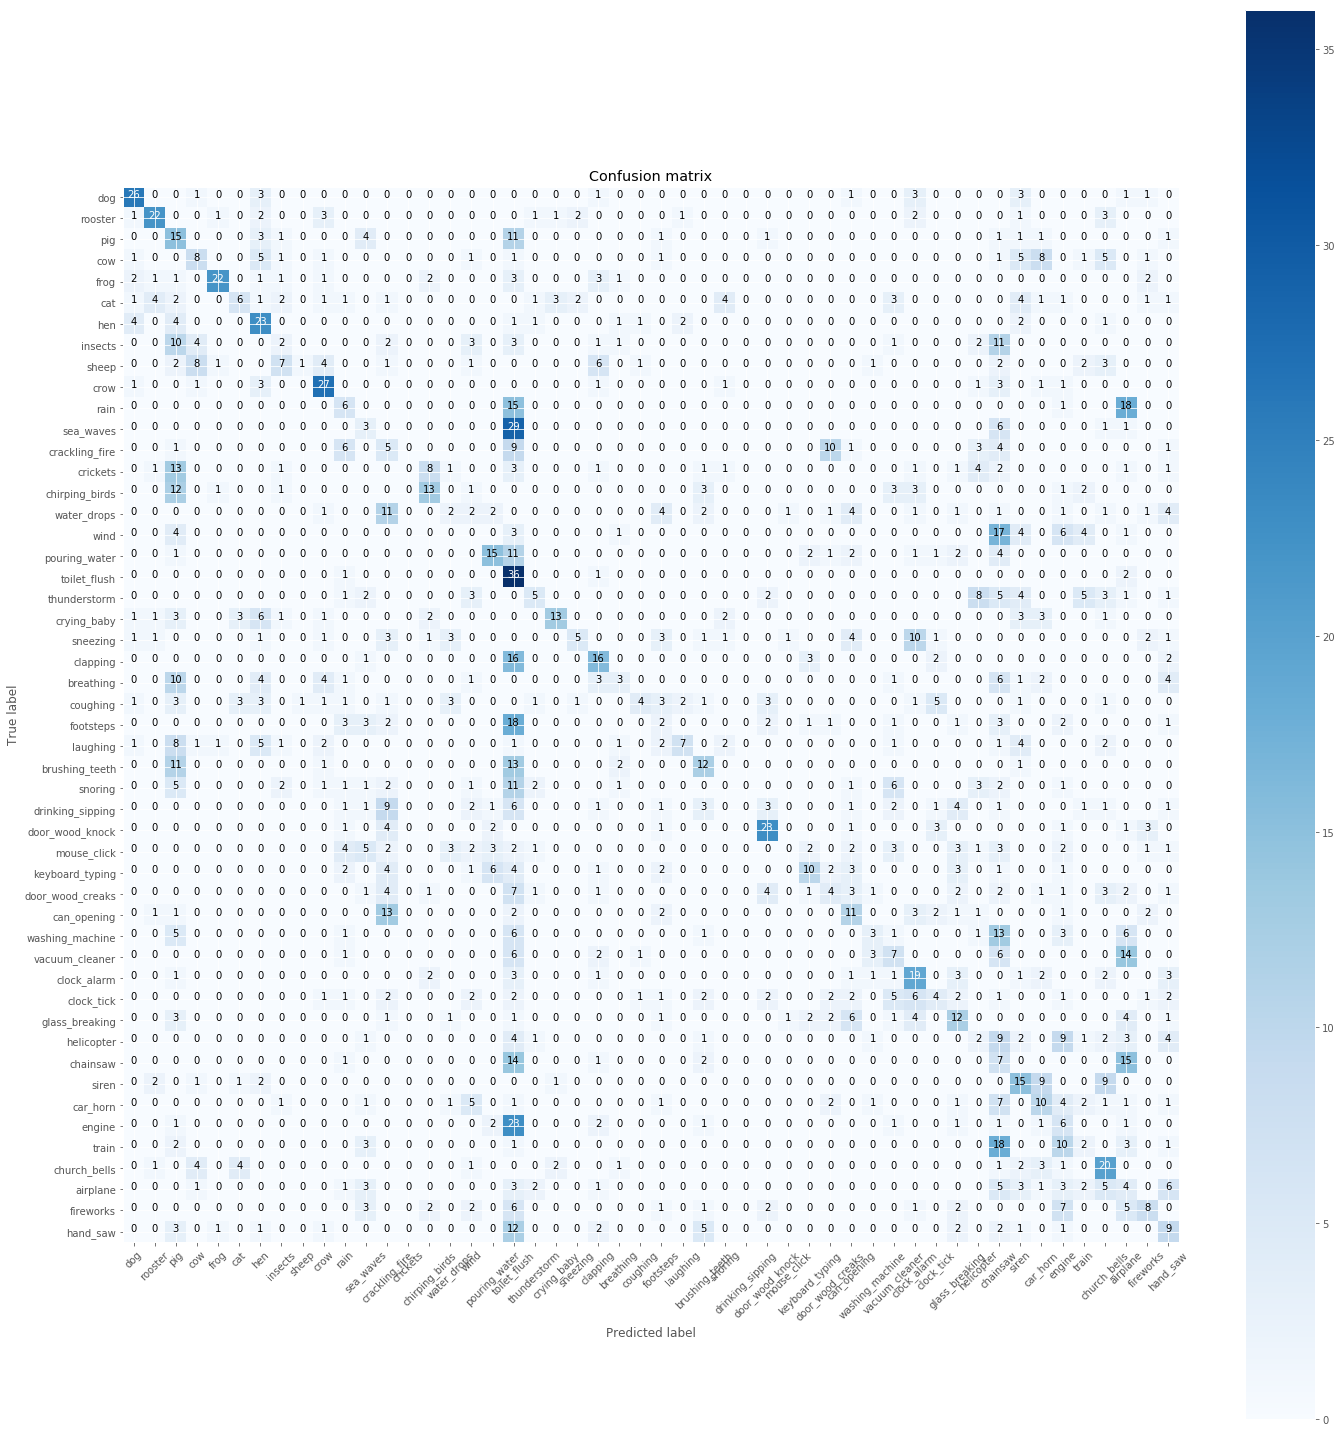

In [56]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

filename      1-100032-A-0.wav
fold                         1
target                       0
category                   dog
esc10                     True
src_file                100032
take                         A
h_category                   0
Name: 0, dtype: object


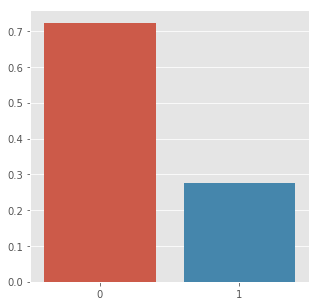

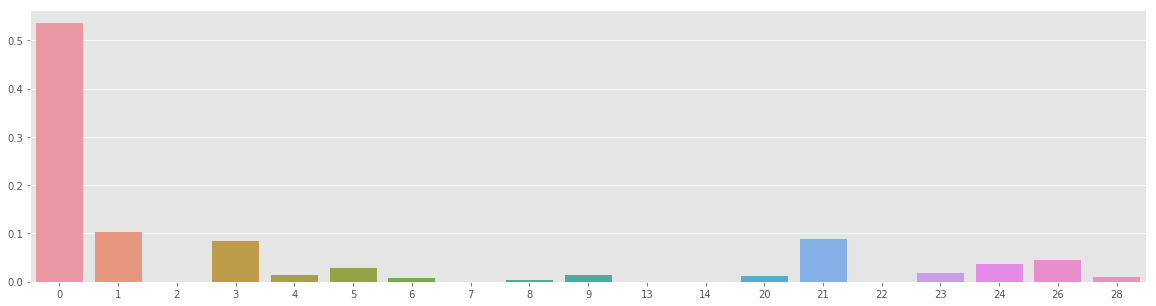

filename      1-100038-A-14.wav
fold                          1
target                       14
category         chirping_birds
esc10                     False
src_file                 100038
take                          A
h_category                    0
Name: 1, dtype: object


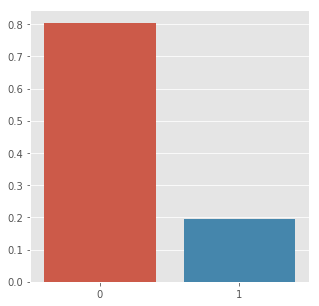

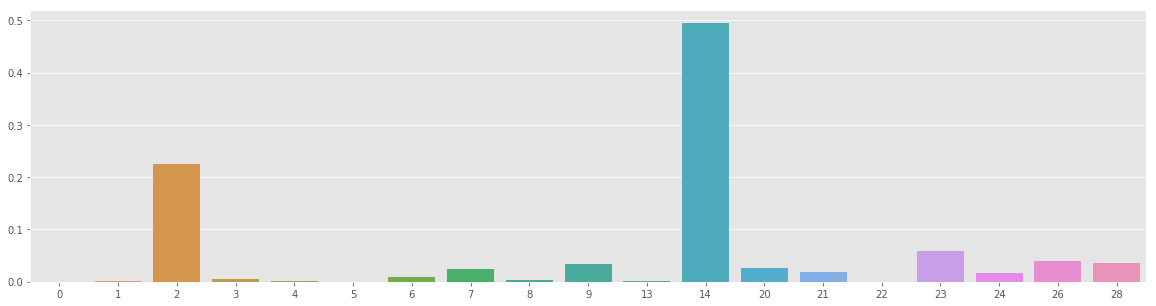

filename      1-100210-A-36.wav
fold                          1
target                       36
category         vacuum_cleaner
esc10                     False
src_file                 100210
take                          A
h_category                    1
Name: 2, dtype: object


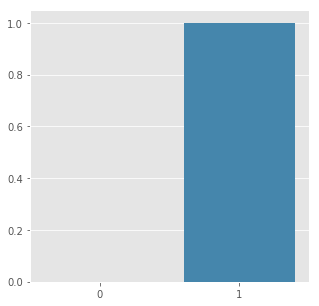

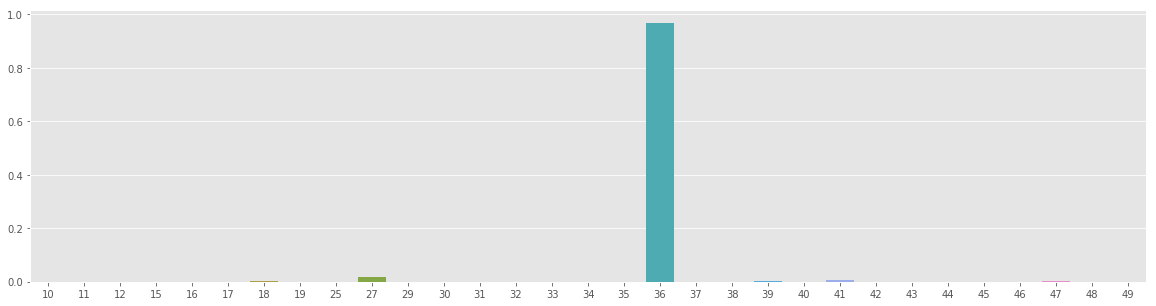

filename      1-100210-B-36.wav
fold                          1
target                       36
category         vacuum_cleaner
esc10                     False
src_file                 100210
take                          B
h_category                    1
Name: 3, dtype: object


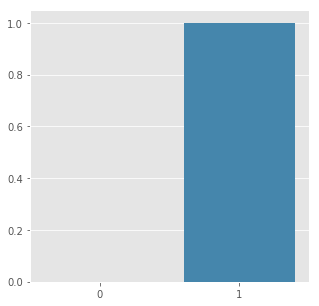

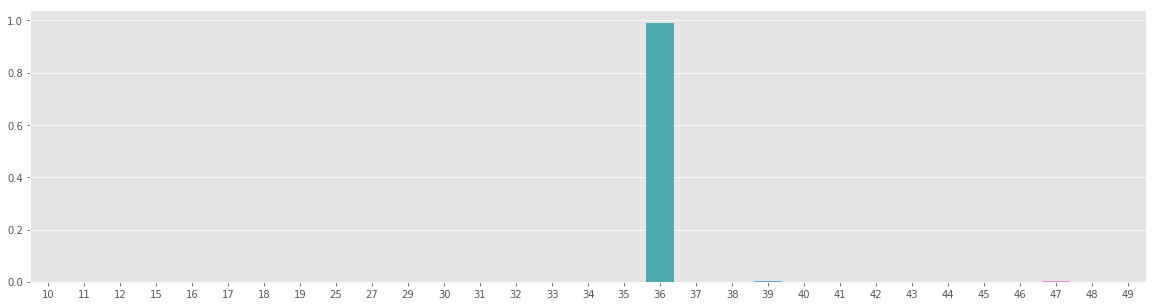

filename      1-101296-A-19.wav
fold                          1
target                       19
category           thunderstorm
esc10                     False
src_file                 101296
take                          A
h_category                    1
Name: 4, dtype: object


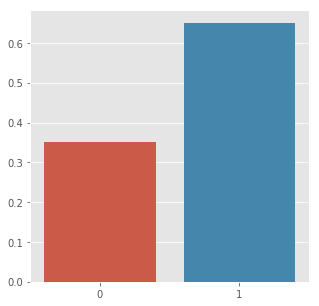

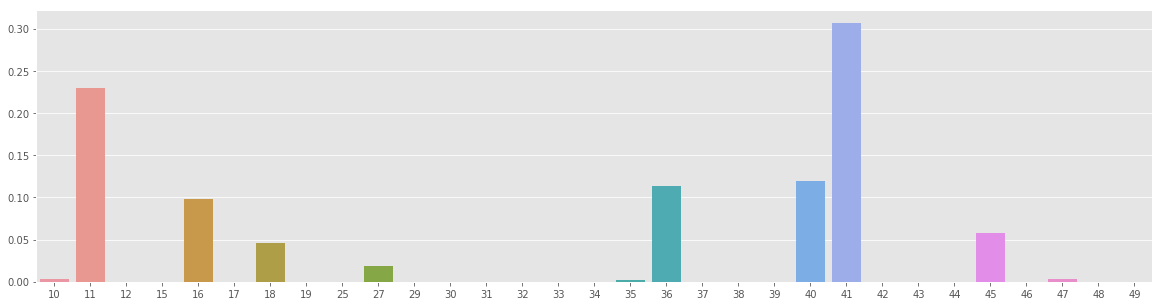

filename      1-101296-B-19.wav
fold                          1
target                       19
category           thunderstorm
esc10                     False
src_file                 101296
take                          B
h_category                    1
Name: 5, dtype: object


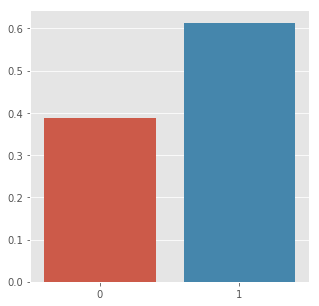

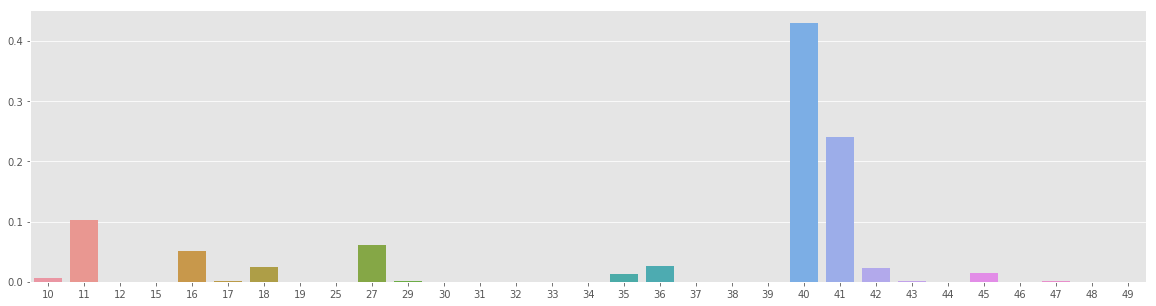

filename      1-101336-A-30.wav
fold                          1
target                       30
category        door_wood_knock
esc10                     False
src_file                 101336
take                          A
h_category                    1
Name: 6, dtype: object


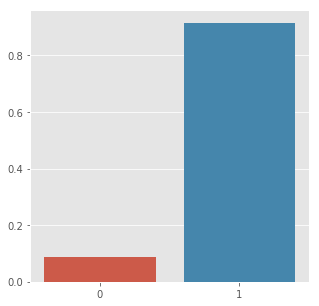

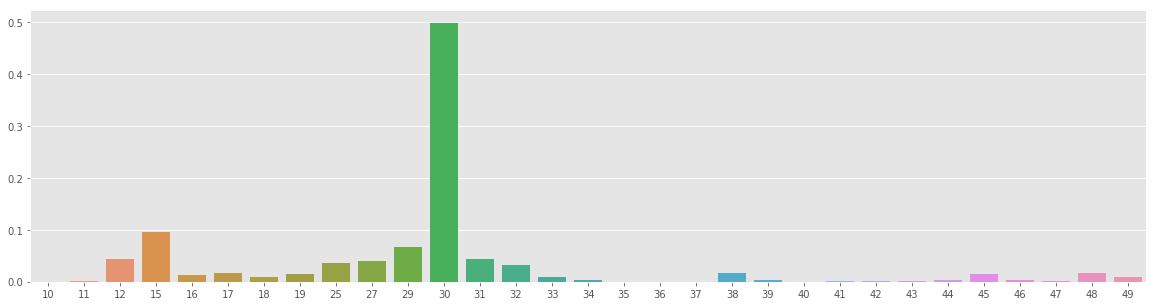

filename      1-101404-A-34.wav
fold                          1
target                       34
category            can_opening
esc10                     False
src_file                 101404
take                          A
h_category                    1
Name: 7, dtype: object


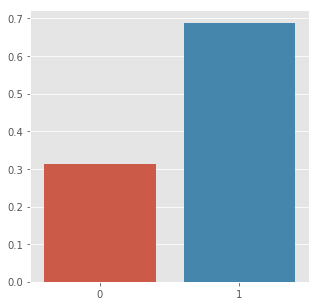

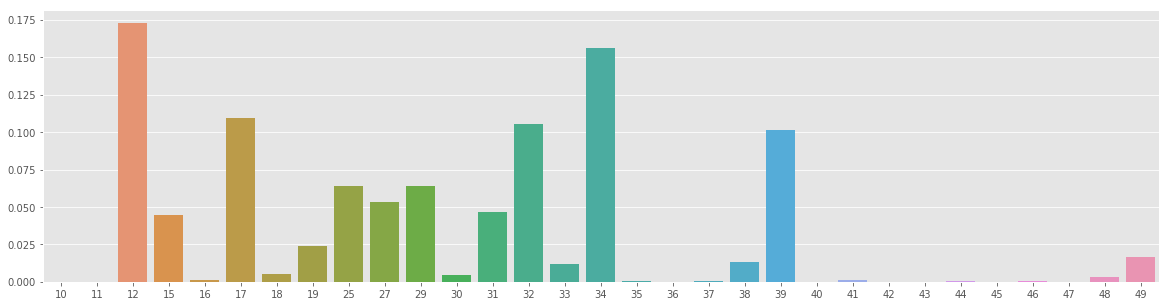

filename      1-103298-A-9.wav
fold                         1
target                       9
category                  crow
esc10                    False
src_file                103298
take                         A
h_category                   0
Name: 8, dtype: object


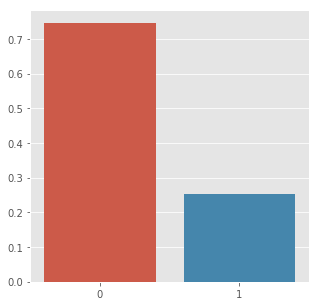

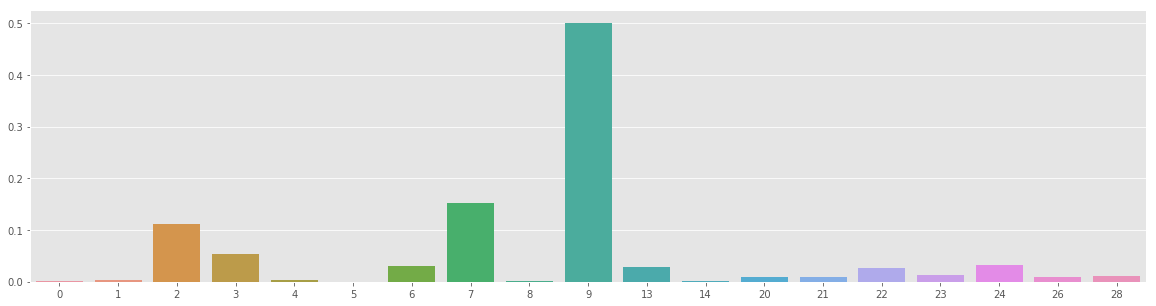

filename      1-103995-A-30.wav
fold                          1
target                       30
category        door_wood_knock
esc10                     False
src_file                 103995
take                          A
h_category                    1
Name: 9, dtype: object


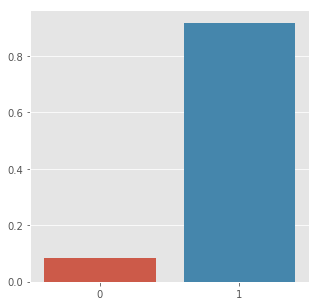

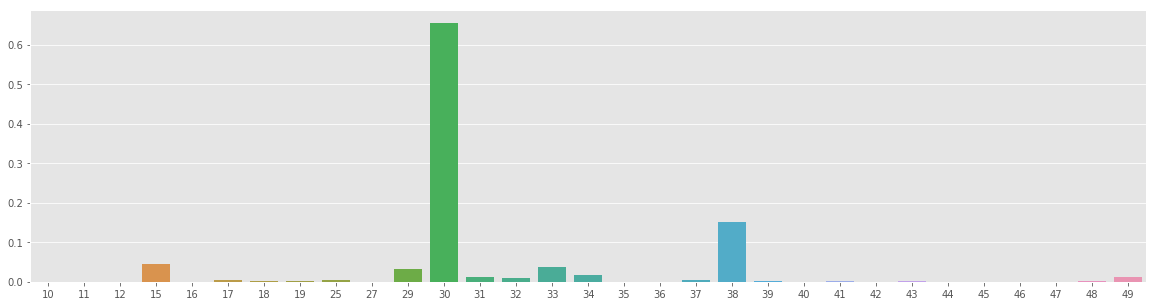

filename      1-103999-A-30.wav
fold                          1
target                       30
category        door_wood_knock
esc10                     False
src_file                 103999
take                          A
h_category                    1
Name: 10, dtype: object


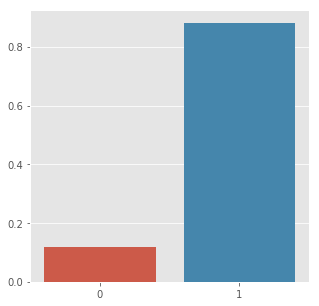

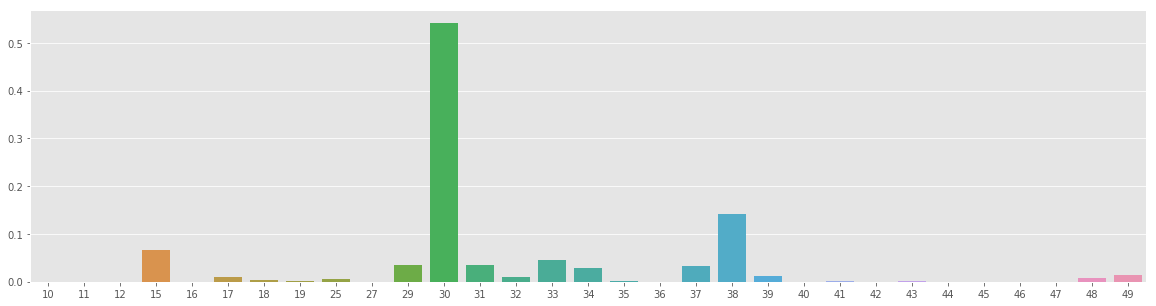

filename      1-104089-A-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 104089
take                          A
h_category                    0
Name: 11, dtype: object


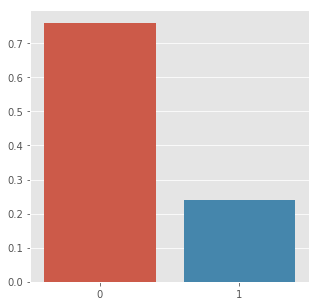

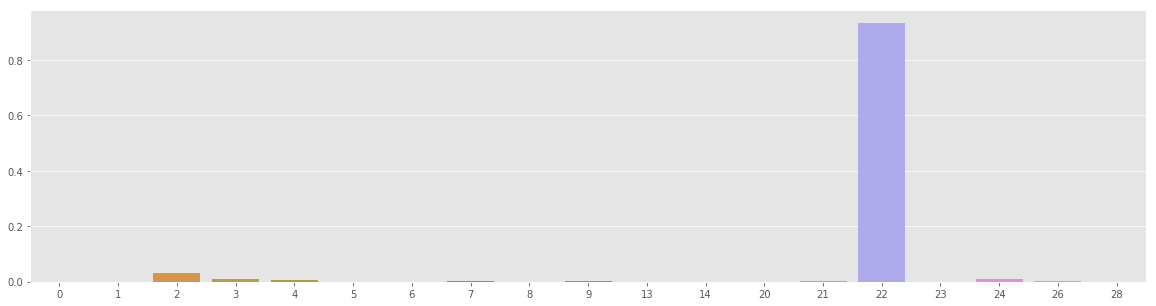

filename      1-104089-B-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 104089
take                          B
h_category                    0
Name: 12, dtype: object


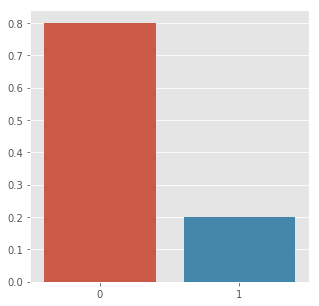

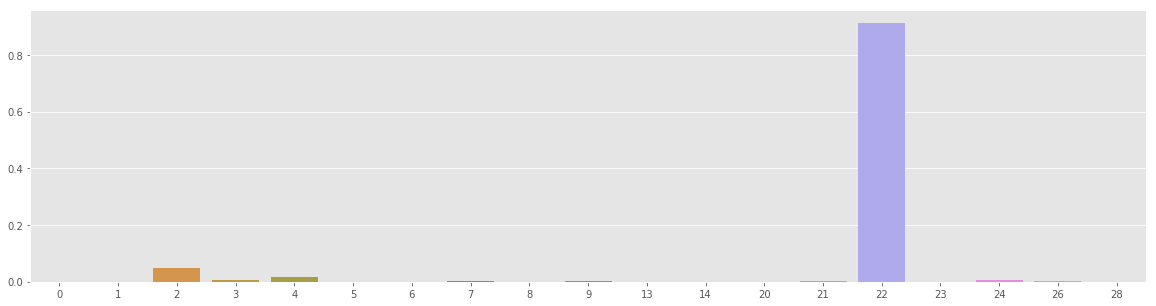

filename      1-105224-A-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 105224
take                          A
h_category                    0
Name: 13, dtype: object


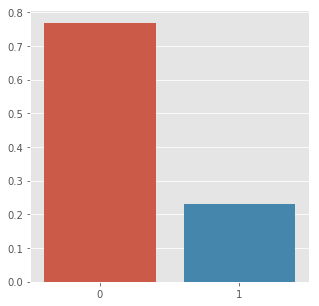

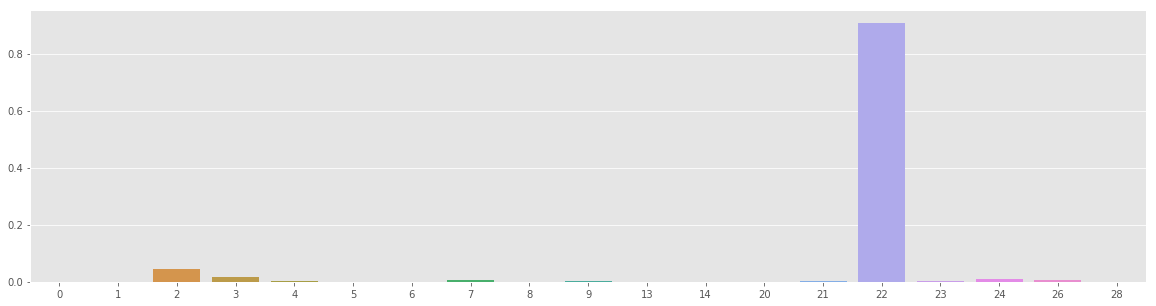

filename      1-110389-A-0.wav
fold                         1
target                       0
category                   dog
esc10                     True
src_file                110389
take                         A
h_category                   0
Name: 14, dtype: object


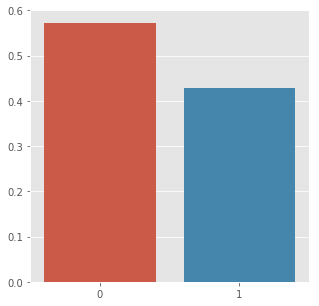

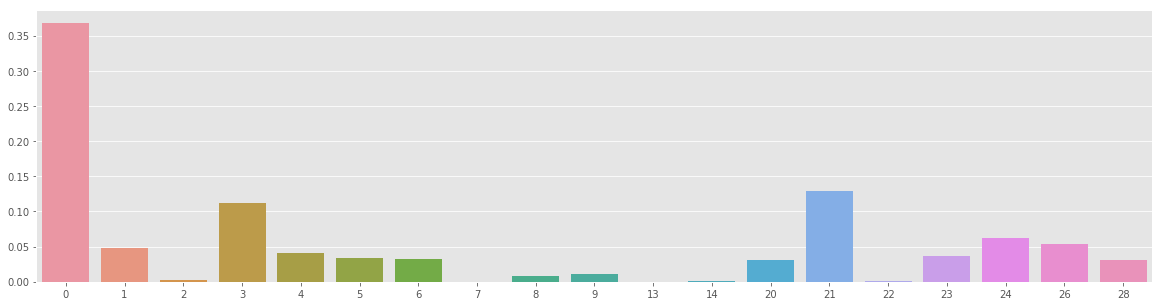

filename      1-110537-A-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 110537
take                          A
h_category                    0
Name: 15, dtype: object


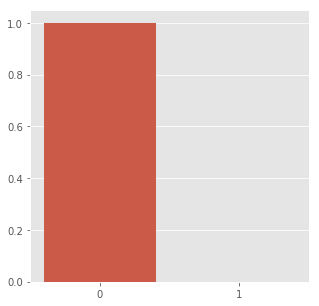

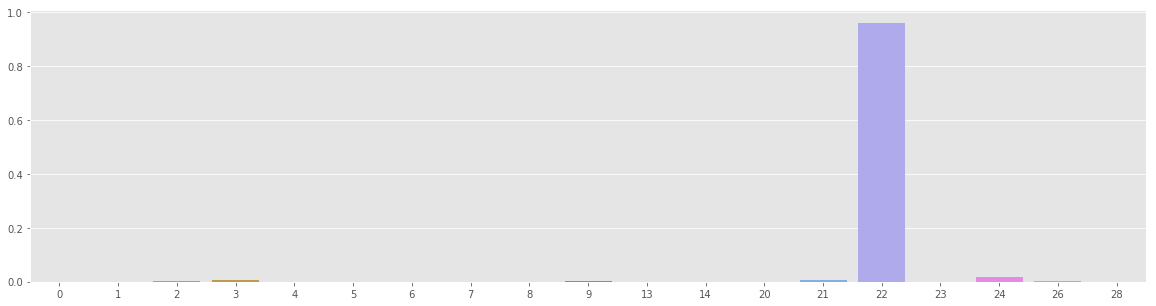

filename      1-115521-A-19.wav
fold                          1
target                       19
category           thunderstorm
esc10                     False
src_file                 115521
take                          A
h_category                    1
Name: 16, dtype: object


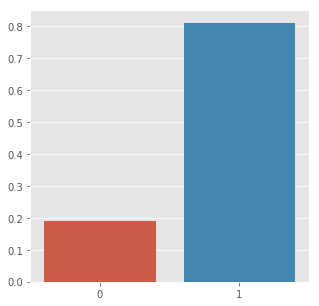

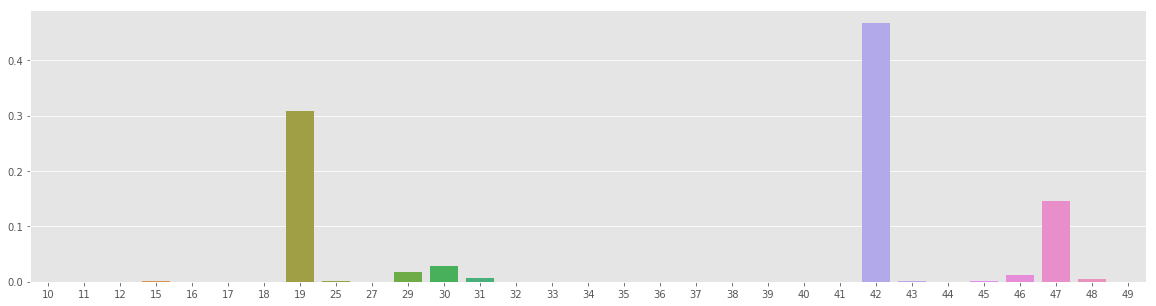

filename      1-115545-A-48.wav
fold                          1
target                       48
category              fireworks
esc10                     False
src_file                 115545
take                          A
h_category                    1
Name: 17, dtype: object


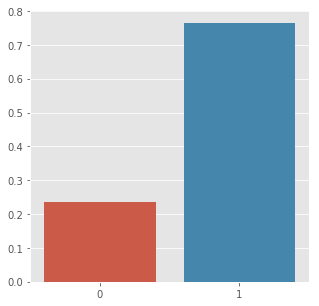

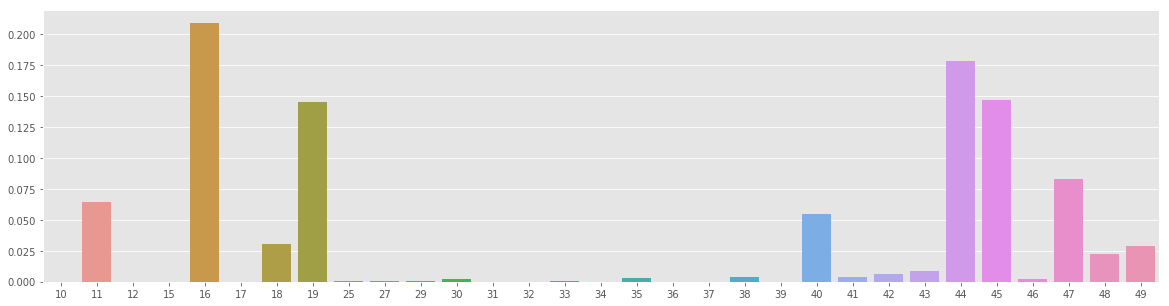

filename      1-115545-B-48.wav
fold                          1
target                       48
category              fireworks
esc10                     False
src_file                 115545
take                          B
h_category                    1
Name: 18, dtype: object


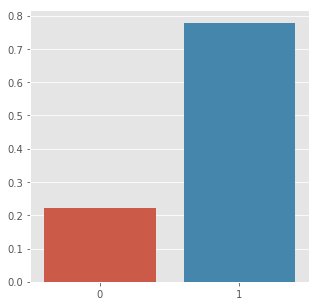

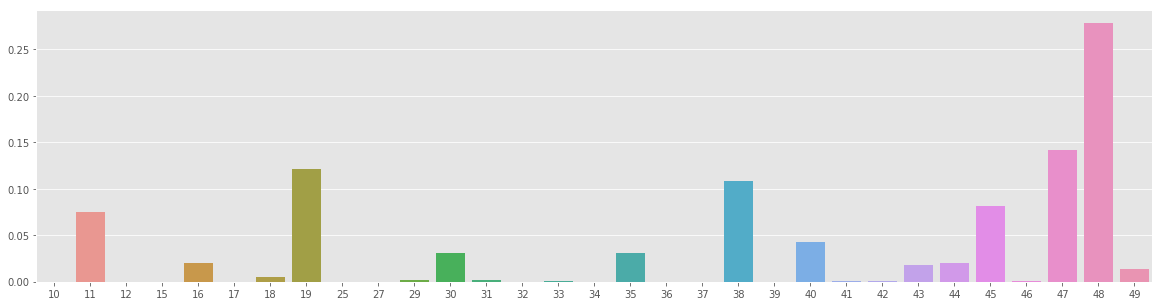

filename      1-115545-C-48.wav
fold                          1
target                       48
category              fireworks
esc10                     False
src_file                 115545
take                          C
h_category                    1
Name: 19, dtype: object


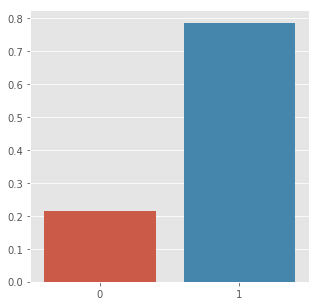

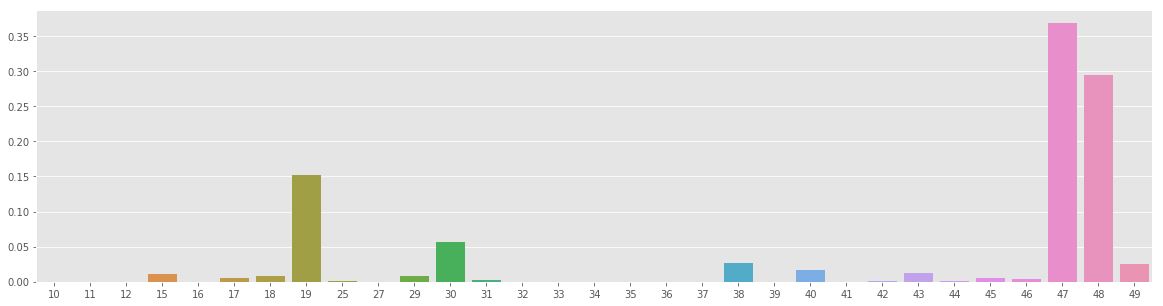

In [57]:
import seaborn as sns

for i in range(0,20):
    prob = pred_probs[i]
    print(dataset.iloc[i])

    xs = np.unique(targets)
    ys = np.average(top_pred_probs[i], axis=0)

    plt.figure(figsize=(5,5))
    sns.barplot(xs, ys)
    
    xs = np.unique(a_targ)
    ys = np.average(prob, axis=0)
    if(len(ys)!=len(xs)):
        xs = np.unique(i_targ)

    plt.figure(figsize=(20,5))
    sns.barplot(xs, ys)
    plt.show()